### Importing Libraries

In [2]:
from importlib.metadata import version
import torch
import tiktoken

from model import *
from utils import *
import importlib.metadata
import importlib
import sys

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow",
]

for p in pkgs:
    try:
        print(f"{p} version: {importlib.metadata.version(p)}")
    except importlib.metadata.PackageNotFoundError:
        try:
            mod = importlib.import_module(p)
            print(f"{p} version (from __version__): {mod.__version__}")
        except Exception:
            print(f"{p} version: could not be determined")

matplotlib version: 3.9.2
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.5.1+cu121
tensorflow version: could not be determined


### Configuration

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Shortened context length (orig: 1024)
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-key-value bias
}

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # Disable dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [5]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# Before trainin, we are just testing the model with a few tokens
token_ids = generate(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

print(f"Output text: {token_ids_to_text(token_ids, tokenizer)}.")

Output text: Every effort moves you rentingetic wasnم refres RexMeCHicular stren.


### Data Loading

#### Dummy Text Data

In [ ]:
# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode("utf-8")
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()
# # First 100 characters
# print(text_data[:99])

# total_characters = len(text_data)
# total_tokens = len(tokenizer.encode(text_data))

# print("Characters:", total_characters)
# print("Tokens:", total_tokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
Characters: 20479
Tokens: 5145


In [ ]:
# # Train/validation ratio
# train_ratio = 0.90
# split_idx = int(train_ratio * len(text_data))
# train_data = text_data[:split_idx]
# val_data = text_data[split_idx:]


# torch.manual_seed(123)

# train_loader = create_dataloader_v1(
#     train_data,
#     batch_size=2,
#     max_length=GPT_CONFIG_124M["context_length"],
#     stride=GPT_CONFIG_124M["context_length"],
#     drop_last=True,
#     shuffle=True,
#     num_workers=0,
# )

# val_loader = create_dataloader_v1(
#     val_data,
#     batch_size=2,
#     max_length=GPT_CONFIG_124M["context_length"],
#     stride=GPT_CONFIG_124M["context_length"],
#     drop_last=False,
#     shuffle=False,
#     num_workers=0,
# )

In [ ]:
# # Sanity check

# if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the training loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "increase the `training_ratio`")

# if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the validation loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "decrease the `training_ratio`")

#### Actual Dataset

In [6]:
from datasets import load_dataset

DATASET_NAME = "roneneldan/TinyStories"
DATASET_DIR = "./dataset/"

dataset = load_dataset(DATASET_NAME, cache_dir=DATASET_DIR)

In [7]:
train_data = [_["text"] for _ in dataset["train"]]
val_data = [_["text"] for _ in dataset["validation"]]

In [8]:
train_loader = create_dataloader_v2(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v2(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [9]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

### Training the LLM

In [10]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Only for Apple Silicon (Mac)
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")
model.to(device)


Using cuda device.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [21]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [22]:
import os
import time
import torch
from tqdm import tqdm

def load_checkpoint(model, optimizer, checkpoint_path, device):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"[Checkpoint Loaded] Epoch: {checkpoint['epoch']}, Step: {checkpoint['step']}")
        return checkpoint['epoch'] + 1, checkpoint['step'], checkpoint['tokens_seen'], checkpoint['best_val_loss']
    else:
        return 0, -1, 0, float('inf')  # Start fresh

def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
    checkpoint_path="checkpoint.pt",
    best_model_path="best_model.pt"
):
    # Load checkpoint if exists
    start_epoch, global_step, tokens_seen, best_val_loss = load_checkpoint(model, optimizer, checkpoint_path, device)
    train_losses, val_losses, track_tokens_seen = [], [], []

    try:
        for epoch in range(start_epoch, num_epochs):
            model.train()
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for input_batch, target_batch in loop:
                optimizer.zero_grad()
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                loss.backward()
                optimizer.step()

                tokens_seen += input_batch.numel()
                global_step += 1
                loop.set_postfix(loss=loss.item())

                # Optional mid-training eval (rare for large models)
                if global_step % eval_freq == 0:
                    train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"[Step {global_step}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Epoch-end evaluation
            train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)

            print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"[Saved New Best Model @ Epoch {epoch+1}]")

            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'step': global_step,
                'tokens_seen': tokens_seen,
                'best_val_loss': best_val_loss,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)

            # Show generated sample
            generate_and_print_sample(model, tokenizer, device, start_context)

    except KeyboardInterrupt:
        print("\n[Training Interrupted] Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'step': global_step,
            'tokens_seen': tokens_seen,
            'best_val_loss': best_val_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print("[Checkpoint Saved Successfully]")

    return train_losses, val_losses, track_tokens_seen

In [1]:
# ========== Execution Start ==========
import time

start_time = time.time()

# Set seed
torch.manual_seed(123)

# Initialize model, move to device
model = GPTModel(GPT_CONFIG_124M).to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# Run training (resumable + interrupt-safe)
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=1,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

# ========== Execution End ==========
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


NameError: name 'torch' is not defined

In [14]:
# Note:
# Uncomment the following code to calculate the execution time
import time

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.532, Val loss 9.460
Ep 1 (Step 000005): Train loss 7.736, Val loss 7.743
Ep 1 (Step 000010): Train loss 6.890, Val loss 6.603
Ep 1 (Step 000015): Train loss 6.298, Val loss 6.163
Ep 1 (Step 000020): Train loss 6.397, Val loss 5.862
Ep 1 (Step 000025): Train loss 5.600, Val loss 5.745
Ep 1 (Step 000030): Train loss 5.546, Val loss 5.646
Ep 1 (Step 000035): Train loss 5.721, Val loss 5.502
Ep 1 (Step 000040): Train loss 5.722, Val loss 5.412
Ep 1 (Step 000045): Train loss 5.351, Val loss 5.303
Ep 1 (Step 000050): Train loss 5.374, Val loss 5.177
Ep 1 (Step 000055): Train loss 5.120, Val loss 5.132
Ep 1 (Step 000060): Train loss 5.513, Val loss 5.053
Ep 1 (Step 000065): Train loss 5.042, Val loss 4.998
Ep 1 (Step 000070): Train loss 5.122, Val loss 4.968
Ep 1 (Step 000075): Train loss 4.812, Val loss 4.927
Ep 1 (Step 000080): Train loss 4.758, Val loss 4.881
Ep 1 (Step 000085): Train loss 4.687, Val loss 4.813
Ep 1 (Step 000090): Train loss 4.915, Val loss

KeyboardInterrupt: 

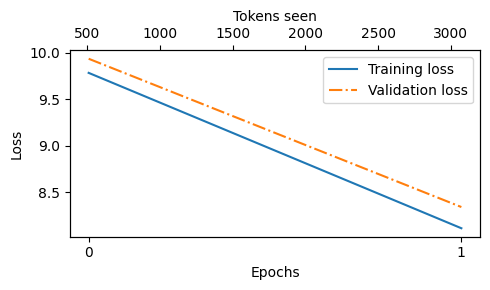

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Saving Model

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();